Data Source: https://www.coingecko.com/id/coins/pepe/historical_data <br>
Daily Data Pepe/usdt from 2023-04-18 to 2025-05-22

# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA 
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats
from scipy.stats import chi2
import pylab
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [5]:
df = pd.read_csv('pepe-usd-max.csv', index_col='snapped_at', parse_dates=['snapped_at'])
df.sort_index(inplace=True) 
df

,price,market_cap,total_volume
snapped_at,,,
2023-04-18 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07
2023-04-19 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07
2023-04-20 00:00:00+00:00,2.487981e-07,1.038897e+08,1.352704e+08
2023-04-21 00:00:00+00:00,3.043395e-07,1.290953e+08,9.738934e+07
2023-04-22 00:00:00+00:00,1.993084e-07,8.356274e+07,7.811382e+07
...,...,...,...
2025-05-18 00:00:00+00:00,1.217309e-05,5.122511e+09,9.805262e+08
2025-05-19 00:00:00+00:00,1.347258e-05,5.642888e+09,2.140867e+09
2025-05-20 00:00:00+00:00,1.322485e-05,5.550022e+09,1.780551e+09


In [6]:
df_pepe = df.copy()
df_pepe

,price,market_cap,total_volume
snapped_at,,,
2023-04-18 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07
2023-04-19 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07
2023-04-20 00:00:00+00:00,2.487981e-07,1.038897e+08,1.352704e+08
2023-04-21 00:00:00+00:00,3.043395e-07,1.290953e+08,9.738934e+07
2023-04-22 00:00:00+00:00,1.993084e-07,8.356274e+07,7.811382e+07
...,...,...,...
2025-05-18 00:00:00+00:00,1.217309e-05,5.122511e+09,9.805262e+08
2025-05-19 00:00:00+00:00,1.347258e-05,5.642888e+09,2.140867e+09
2025-05-20 00:00:00+00:00,1.322485e-05,5.550022e+09,1.780551e+09


# Checking Missing Values

In [8]:
df_pepe.isnull().sum()

price           0
market_cap      0
total_volume    0
dtype: int64

# Set Frequency

In [10]:
df_pepe = df_pepe.asfreq('d')

In [11]:
df_pepe.isnull().sum()

price           0
market_cap      0
total_volume    0
dtype: int64

# Exploratory Data Analysis Time Series

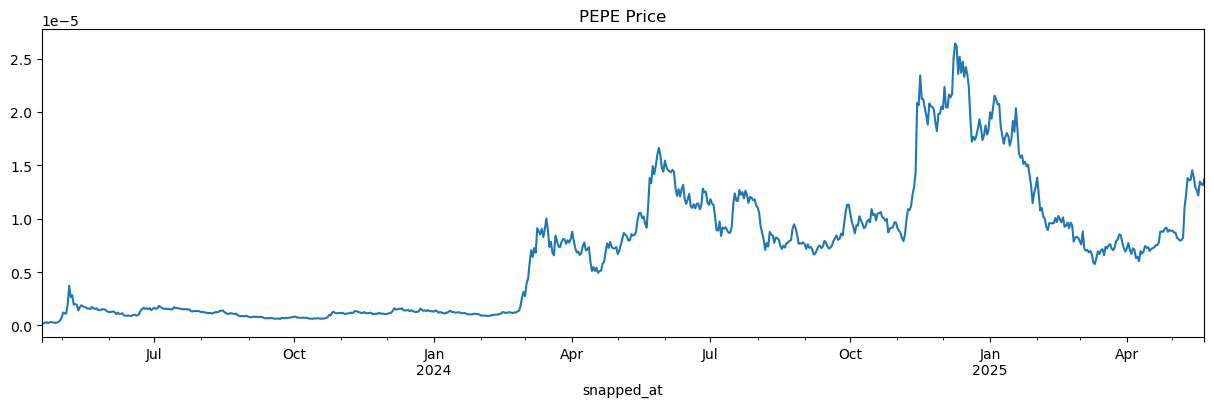

In [13]:
plt.figure(figsize=(15, 4))
df_pepe["price"].plot(title='PEPE Price')
plt.show()

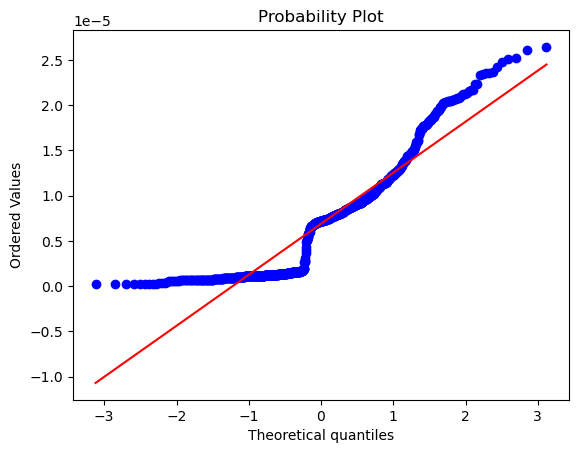

In [14]:
stats.probplot(df_pepe['price'], plot=pylab)
pylab.show()

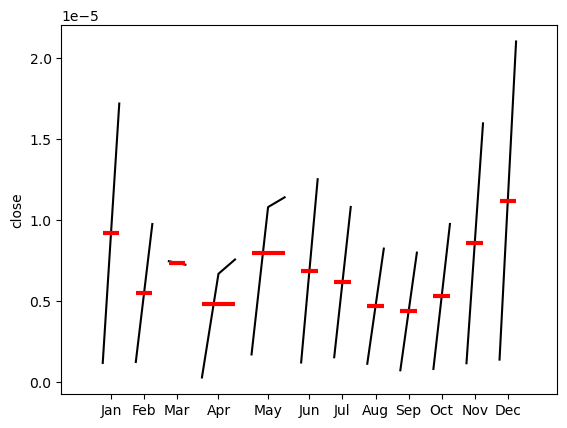

In [15]:
#montly seasonality
month_plot(df_pepe["price"].resample("ME").mean(),
          ylabel='close')
plt.show()

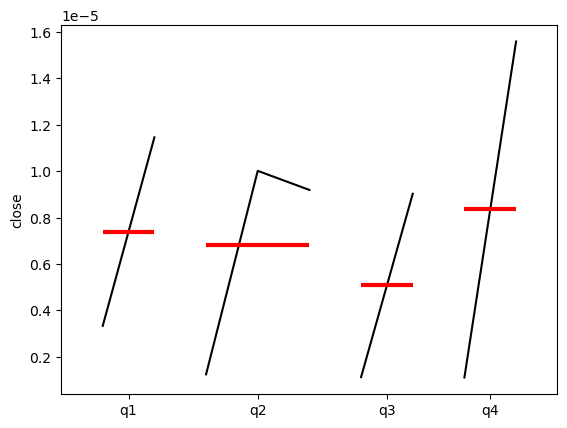

In [16]:
#quarter plot
quarter_plot(df_pepe["price"].resample("QE").mean(),
          ylabel='close')
plt.show()

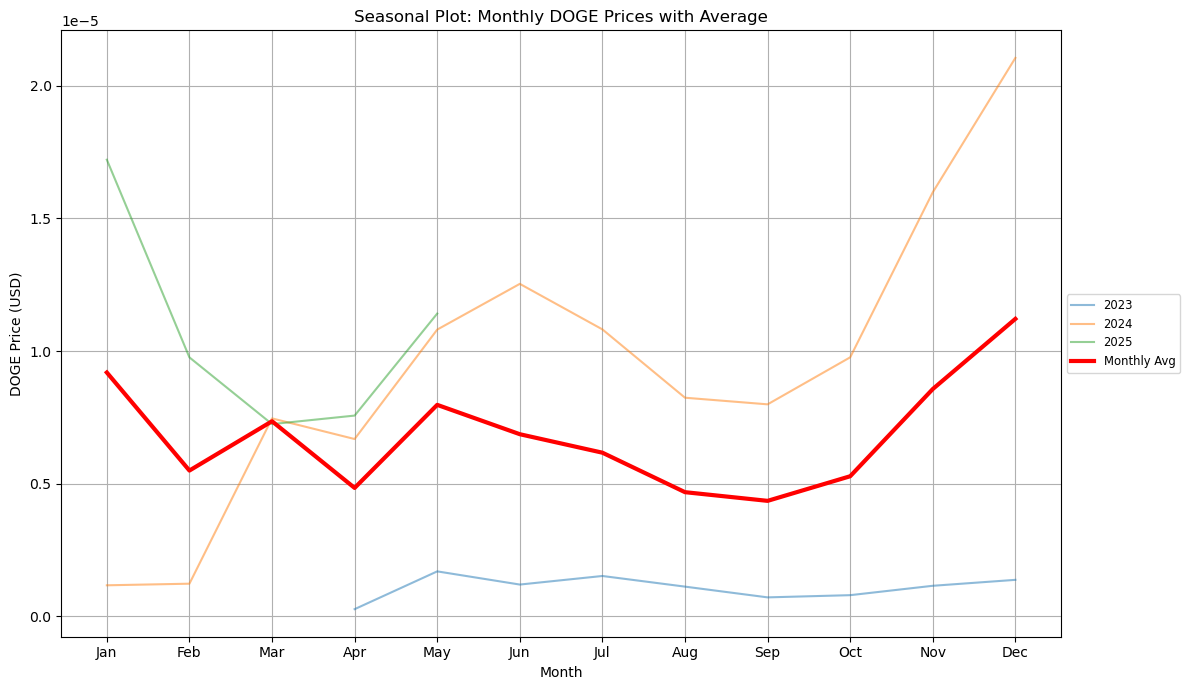

In [17]:
# MONTLY
# Ensure the index is datetime (just in case)
df_pepe.index = pd.to_datetime(df_pepe.index)

# Extract year and month from the index
df_pepe['Year'] = df_pepe.index.year
df_pepe['Month'] = df_pepe.index.strftime('%b')

# Create the pivot table
pivot_df = df_pepe.pivot_table(index='Month', columns='Year', values='price', aggfunc='mean')

# Reorder the months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pivot_df = pivot_df.reindex(month_order)

plt.figure(figsize=(12, 7))

for year in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[year], label=str(year), alpha=0.5)

monthly_avg = pivot_df.mean(axis=1)
plt.plot(pivot_df.index, monthly_avg, color='red', linewidth=3, label='Monthly Avg')

plt.title('Seasonal Plot: Monthly DOGE Prices with Average')
plt.xlabel('Month')
plt.ylabel('DOGE Price (USD)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



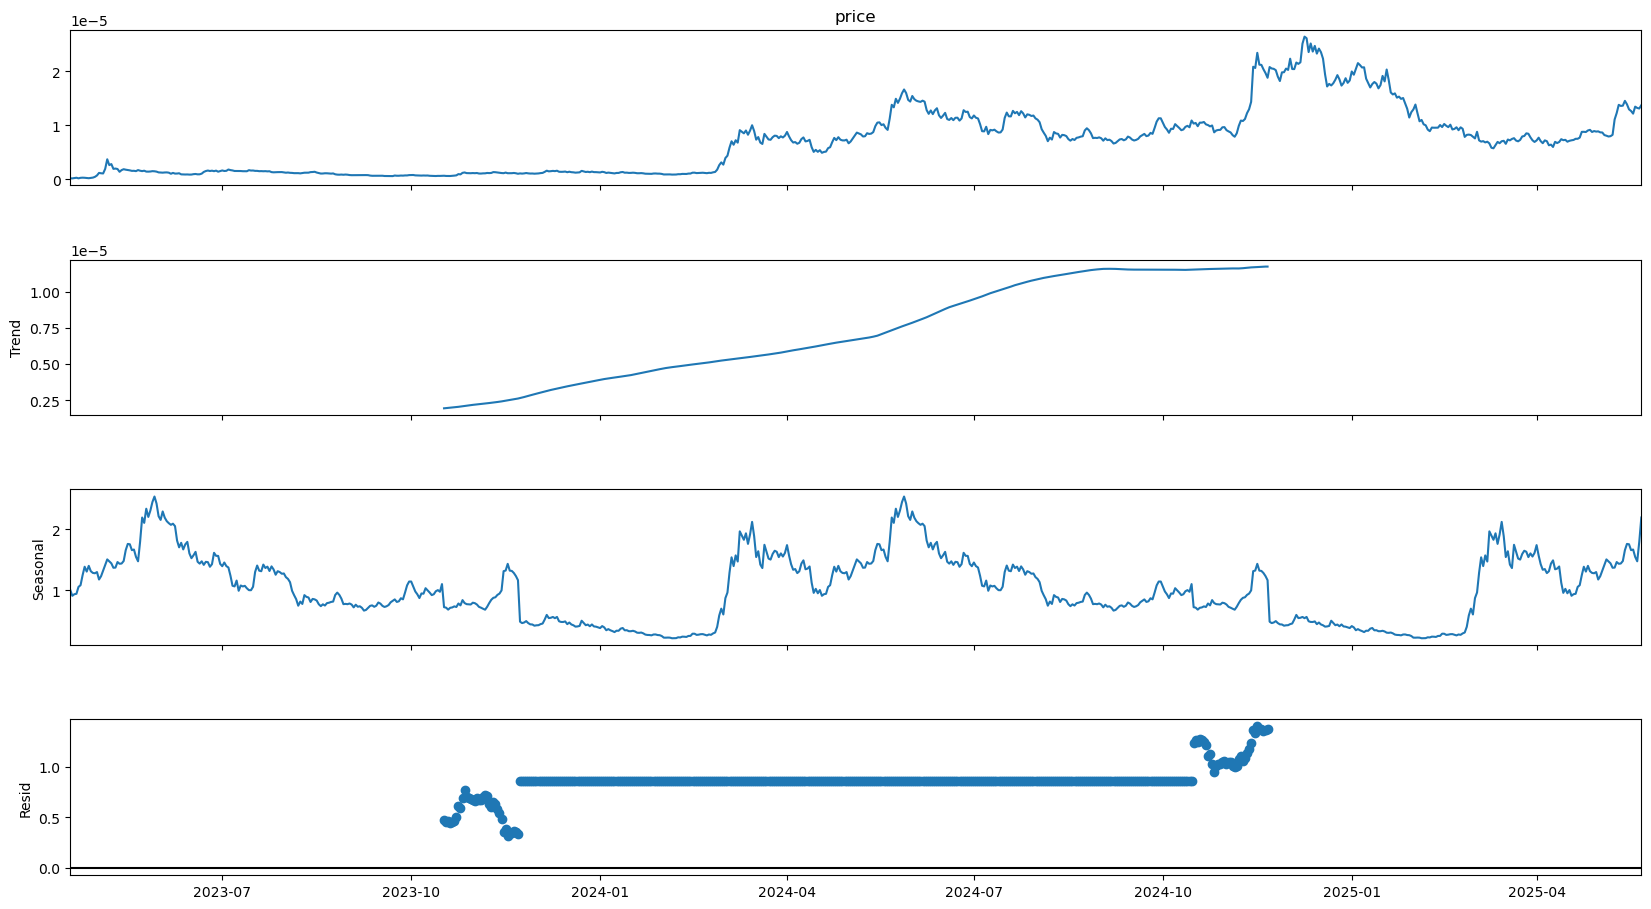

In [18]:
# Seasonal decomposition for df['Adj. Close']
decomposition = seasonal_decompose(df_pepe['price'],
                                  model = 'mull',
                                  period = 365)
fig = decomposition.plot()
fig.set_size_inches(18, 10)
plt.show()

# Split The Data

In [139]:
size = int(len(df_pepe)*0.90) #90/10 split
pepe_train = df_pepe.iloc[:size]
pepe_test = df_pepe.iloc[size:]
pepe_train

,price,market_cap,total_volume,Year,Month
snapped_at,,,,,
2023-04-18 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07,2023,Apr
2023-04-19 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07,2023,Apr
2023-04-20 00:00:00+00:00,2.487981e-07,1.038897e+08,1.352704e+08,2023,Apr
2023-04-21 00:00:00+00:00,3.043395e-07,1.290953e+08,9.738934e+07,2023,Apr
2023-04-22 00:00:00+00:00,1.993084e-07,8.356274e+07,7.811382e+07,2023,Apr
...,...,...,...,...,...
2025-03-02 00:00:00+00:00,7.587407e-06,3.192389e+09,5.321653e+08,2025,Mar
2025-03-03 00:00:00+00:00,8.809667e-06,3.707321e+09,1.155750e+09,2025,Mar
2025-03-04 00:00:00+00:00,7.220139e-06,3.043809e+09,9.777192e+08,2025,Mar


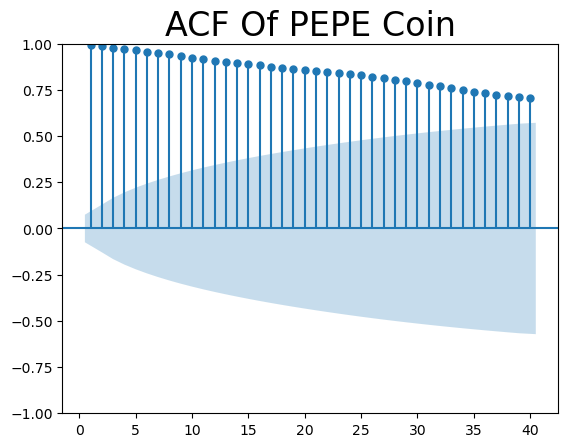

In [141]:
sgt.plot_acf(pepe_train.price, zero = False, lags = 40)
plt.title('ACF Of PEPE Coin',size = 24)
plt.show()

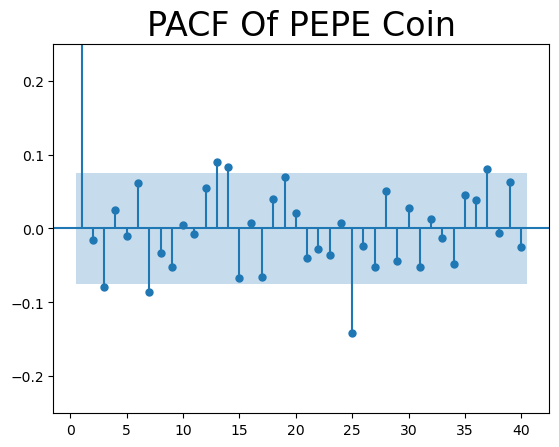

In [143]:
sgt.plot_pacf(pepe_train.price, zero = False, lags = 40)
plt.title('PACF Of PEPE Coin',size = 24)
plt.ylim(-0.25,0.25)
plt.show()

In [145]:
pepe_train['returns'] = pepe_train.price.pct_change(1)*100
pepe_train

,price,market_cap,total_volume,Year,Month,returns
snapped_at,,,,,,
2023-04-18 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07,2023,Apr,NaN
2023-04-19 00:00:00+00:00,1.901222e-07,0.000000e+00,7.231215e+07,2023,Apr,0.000000
2023-04-20 00:00:00+00:00,2.487981e-07,1.038897e+08,1.352704e+08,2023,Apr,30.862164
2023-04-21 00:00:00+00:00,3.043395e-07,1.290953e+08,9.738934e+07,2023,Apr,22.323909
2023-04-22 00:00:00+00:00,1.993084e-07,8.356274e+07,7.811382e+07,2023,Apr,-34.511164
...,...,...,...,...,...,...
2025-03-02 00:00:00+00:00,7.587407e-06,3.192389e+09,5.321653e+08,2025,Mar,-4.104497
2025-03-03 00:00:00+00:00,8.809667e-06,3.707321e+09,1.155750e+09,2025,Mar,16.109063
2025-03-04 00:00:00+00:00,7.220139e-06,3.043809e+09,9.777192e+08,2025,Mar,-18.042996


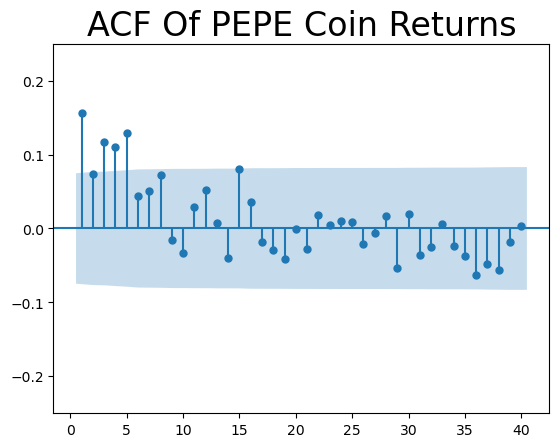

In [147]:
sgt.plot_acf(pepe_train.returns[1:], zero = False, lags = 40)
plt.title('ACF Of PEPE Coin Returns',size = 24)
plt.ylim(-0.25,0.25)
plt.show()

Base on ACF it's might be 5, let's check with number

# Find best parameters

In [151]:
import contextlib
import io

def LLR_test(model1, model2, df=1):
    llf1 = model1.fit().llf
    llf2 = model2.fit().llf
    LR = 2 * (llf2 - llf1)
    return chi2.sf(LR, df)

def compare_ma_models_clean(data, max_q=10):
    print(f"{'MA(q)':<6} {'AIC':<12} {'BIC':<12} {'LLR p-value'}")
    prev_model = None
    for q in range(1, max_q + 1):
        try:
            model = ARIMA(data, order=(0, 0, q))
            # Silence output
            with contextlib.redirect_stdout(io.StringIO()):
                result = model.fit()

            aic = result.aic
            bic = result.bic

            if prev_model:
                with contextlib.redirect_stdout(io.StringIO()):
                    p_val = LLR_test(prev_model, model)
                print(f"{q:<6} {aic:<12.2f} {bic:<12.2f} {p_val:.4f}")
            else:
                print(f"{q:<6} {aic:<12.2f} {bic:<12.2f} {'-'}")

            prev_model = model
        except Exception:
            print(f"{q:<6} {'FAILED':<12} {'FAILED':<12} {'-'}")

In [153]:
returns = pepe_train['returns'][1:]
compare_ma_models_clean(returns, max_q=10)

MA(q)  AIC          BIC          LLR p-value
1      5144.99      5158.59      -
2      5145.61      5163.75      0.2407
3      5142.61      5165.28      0.0253
4      5141.29      5168.49      0.0683
5      5133.40      5165.13      0.0017
6      5134.36      5170.63      0.3079
7      5135.54      5176.35      0.3673
8      5134.31      5179.65      0.0722
9      5136.06      5185.93      0.6163
10     5134.35      5188.76      0.0542


As we could see the best LLR value and AIC/BIC is at Moving Average 5 Therefore we will use it.

# Stationarity and differencing

In [156]:
adf_result = adfuller(pepe_train.returns[1:])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("⚠️ Series is NOT stationary. Consider differencing.")

ADF Statistic: -8.898537077036902
p-value: 1.188604446858034e-14
✅ Series is stationary


# Model Training

In [158]:
model_ret_ma_5= ARIMA(pepe_train.returns[1:], order=(0,0,5))
results_ret_ma_5 = model_ret_ma_5.fit()
results_ret_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  688
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -2559.698
Date:                Fri, 23 May 2025   AIC                           5133.397
Time:                        14:58:58   BIC                           5165.133
Sample:                    04-19-2023   HQIC                          5145.675
                         - 03-06-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9853      0.700      1.408      0.159      -0.386       2.356
ma.L1          0.1237      0.018      6.955      0.000       0.089       0.159
ma.L2          0.0370      0.021      1.757      0.079      -0.004       0.078
ma.L3          0.0751      0.020      3.799      0.000       0.036       0.114
ma.L4          0.0792      0.024      3.354      0.001       0.033       0.125
ma.L5          0.1344      0.021      6.425      0.000       0.093       0.175
sigma2        99.7750      2.760     36.151      0.000      94.366     105.184
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4244.32
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             1.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Plot the Data & Forecasting

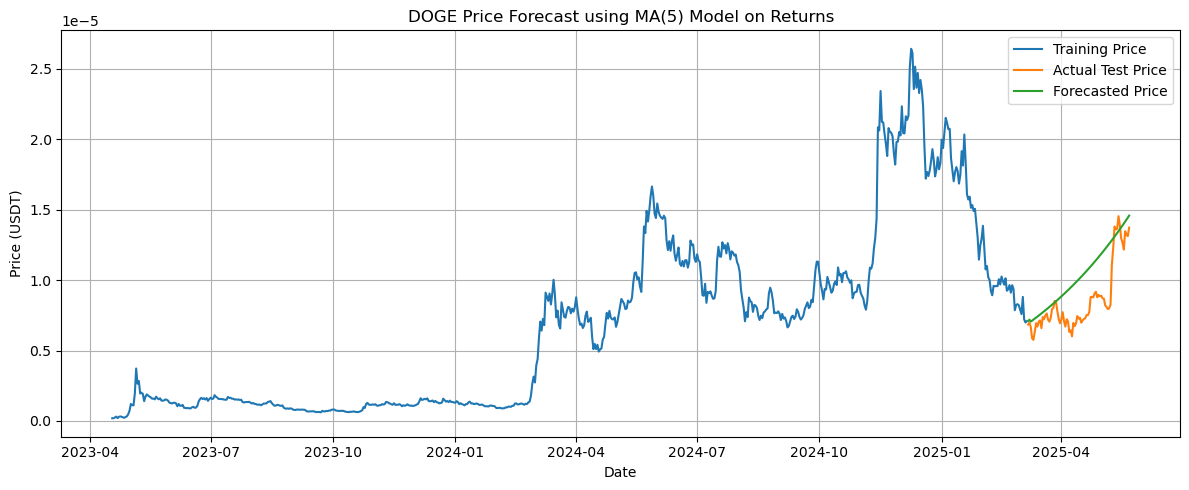

In [160]:
# === Step 1: Forecast returns ===
forecast_steps = len(pepe_test)
pred_returns = results_ret_ma_5.predict(
    start=len(pepe_train.returns[1:]), 
    end=len(pepe_train.returns[1:]) + forecast_steps - 1
)

# === Step 2: Reconstruct forecasted prices ===
# Convert percentage returns to multipliers
# e.g. 30% -> 1.30, -10% -> 0.90
return_multipliers = 1 + (pred_returns / 100)

# Start from last known actual price
last_price = pepe_train['price'].iloc[-1]

# Compute cumulative product of returns to get forecast prices
forecast_prices = return_multipliers.cumprod() * last_price

# Align forecasted prices with test set dates
forecast_series = pd.Series(data=forecast_prices.values, index=pepe_test.index)

# === Step 3: Plot actual vs forecast ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(pepe_train['price'], label="Training Price")
plt.plot(pepe_test['price'], label="Actual Test Price")
plt.plot(forecast_series, label="Forecasted Price")
plt.title("DOGE Price Forecast using MA(5) Model on Returns")
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Not a really good model therefore we need ARMA/ARIMA MODEL.